# The KoLeo loss

The KoLeo loss is a regularizer that pushes representations to spread uniformly in their space by maximizing their minimum distance from each other.

## Where does the KoLeo loss come from?

The KoLeo loss was introduced in this [paper](https://arxiv.org/pdf/1806.03198). It is a loss function derived from the Kozachenko–Leonenko estimator. It allows approximating Shannon entropy using distances to the k nearest neighbors. If you want to learn more about this estimator, I recommend visiting this [page](https://infomeasure.readthedocs.io/en/stable/guide/entropy/kozachenko_leonenko/).

The DINO family of self-supervised learning models has implemented this loss which you can find [here](https://github.com/facebookresearch/dinov2/blob/main/dinov2/loss/koleo_loss.py).

The KoLeo loss is defined as follows

$$ \mathcal{L}_{KoLeo} = - \frac{1}{n} \sum_{i=1}^n \log\left( \min_{j \ne i} \| f(x_i) - f(x_j) \| \right). $$

where $n$ is the batch size. For each embedding in the batch, the loss computes the logarithm of its minimum distance to all other embeddings in the same batch. The negative sign ensures that maximizing the minimum distance corresponds to minimizing the loss, encouraging embeddings to spread out in the representation space.

So the total loss becomes

$$ \mathcal{L} = \mathcal{L}_{triplet} + \lambda\mathcal{L}_{KoLeo} $$


One of the key benefits of this loss is preventing *collapse*. Model collapse refers to a failure mode in self-supervised learning where the model learns to map all inputs to the same (or very similar) embedding vector. When collapse occurs, all the learned features are indistinguishable and the model loses its ability to represent meaningful differences between examples, effectively destroying the utility of the learned representations. The KoLeo loss mitigates this by encouraging the embeddings to spread out in the representation space, helping the model avoid this degenerate solution. Here an illustration that comes from the paper:

![Koleo loss illustration](../images/full-koleo-illustration.png)


We will therefore try to integrate the KoLeo loss into our training code and observe the results on our siamese network. Will we observe, as expected, a greater spread of embeddings?

## Integrating the KoLeo loss into the code

First, let's take the KoLeo loss implementation from DINOv2.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.use_deterministic_algorithms(True)

class KoLeoLoss(nn.Module):
    """Kozachenko-Leonenko entropic loss regularizer from Sablayrolles et al. - 2018 - Spreading vectors for similarity search"""

    def __init__(self):
        super().__init__()
        self.pdist = nn.PairwiseDistance(2, eps=0)

    def pairwise_NNs_inner(self, x):
        """
        Pairwise nearest neighbors for L2-normalized vectors.
        Uses Torch rather than Faiss to remain on GPU.
        """
        # parwise dot products (= inverse distance)
        dots = torch.mm(x, x.t())
        n = x.shape[0]
        dots.view(-1)[:: (n + 1)].fill_(-1)  # Trick to fill diagonal with -1
        _, indices = torch.max(dots, dim=1)  # max inner prod -> min distance
        return indices

    def forward(self, student_output, eps=1e-8):
        """
        Args:
            student_output (BxD): backbone output of student
        """
        student_output = F.normalize(student_output, eps=eps, p=2, dim=-1)
        indices = self.pairwise_NNs_inner(student_output)
        distances = self.pdist(student_output, student_output[indices])  # BxD, BxD -> B
        loss = -torch.log(distances + eps).mean()
        return loss


In [10]:
import sys
sys.path.append("../..")

from training_utils import (
    get_device, load_cifar10, build_triplets,
    create_datasets, VGG11Embedding, triplet_loss,
    setup_training_dir, log_metrics, print_metrics, 
    plot_losses, construct_embeddings_by_class, LABEL_NAMES
)


### Training

As in part 1, we start by defining the seed and building our triplets.

For the sake of reproducibility, I set the device to CPU here.
As I am on a Mac, I would normally use 'mps', but the KoLeo loss produces slight differences between same runs on 'mps' for unclear reasons. This requires further investigation, so I will keep everything on CPU for this first run. Later, when using k-fold, we will switch to 'mps', sacrificing reproducibility for speed.



In [11]:
import numpy as np

seed = 42
device = get_device()
device = "cpu"
print(f"Device: {device}")

images, labels = load_cifar10("../cifar-10-python")
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

np.random.seed(seed)
triplets, triplets_labels = build_triplets(images, labels, n_neg=2500, seed=seed)
print(f"Triplets shape: {triplets.shape}")


Device: cpu
Images shape: (50000, 32, 32, 3), Labels shape: (50000,)
Triplets shape: (25000, 3, 32, 32, 3)


Here we add the `koleo_weight` variable, our $\lambda$ parameter of the total loss formula.


In [12]:
batch_size = 64
learning_rate = 5e-4
margin = 0.4
koleo_weight = 0.1
val_split = 0.05

train_dataset, val_dataset, val_triplets, val_labels = create_datasets(triplets, triplets_labels, val_split=val_split, seed=seed)

koleo_loss_fn = KoLeoLoss()

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Train: 23750, Val: 1250


And we rewrite our training loop by inserting the KoLeo loss into the loss calculation.


In [ ]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def train_loop(net, dataloader, optimizer, margin, koleo_weight, print_freq=100):
    net.train()
    loss_accum = 0.0
    epoch_loss = 0.0
    for batch_idx, (anc, pos, neg) in tqdm(enumerate(dataloader)):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)

        t_loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)
        all_embeddings = torch.cat([anc_feat, pos_feat, neg_feat], dim=0)
        k_loss = koleo_loss_fn(all_embeddings)
        if koleo_weight is not None:
            loss = t_loss + koleo_weight * k_loss
        else:
            loss = t_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accum += loss.item()
        epoch_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            print(f"Batch {batch_idx+1}: Loss = {loss_accum / print_freq:.4f}")
            loss_accum = 0.0

    return epoch_loss / (batch_idx + 1)

def validation_loop(net, dataloader, margin, koleo_weight, device):
    net.eval()
    val_loss = 0
    total_simple_loss = 0
    good_triplets = 0
    total_triplets = 0

    positive_similarities = []
    negative_similarities = []
    
    positive_euclidean_distances = []
    negative_euclidean_distances = []

    with torch.no_grad():
        for batch_idx, (anc, pos, neg) in enumerate(dataloader):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
            anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)
            
            simple_loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)
            if koleo_weight is not None:
                loss = simple_loss + koleo_weight * koleo_loss_fn(torch.cat([anc_feat, pos_feat, neg_feat], dim=0))
            else:
                loss = simple_loss

            val_loss += loss.item()
            total_simple_loss += simple_loss.item()

            batch_positive_euclidean_distances = F.pairwise_distance(anc_feat, pos_feat, p=2)
            batch_negative_euclidean_distances = F.pairwise_distance(anc_feat, neg_feat, p=2)
            positive_euclidean_distances.append(batch_positive_euclidean_distances)
            negative_euclidean_distances.append(batch_negative_euclidean_distances)

            batch_positive_similarities = F.cosine_similarity(anc_feat, pos_feat, dim=1)
            batch_negative_similarities = F.cosine_similarity(anc_feat, neg_feat, dim=1)
            positive_similarities.append(batch_positive_similarities)
            negative_similarities.append(batch_negative_similarities)

            good_triplets += (batch_positive_similarities > batch_negative_similarities).sum()
            total_triplets += anc.shape[0]

        positive_euclidean_distances = torch.cat(positive_euclidean_distances, dim=0)
        negative_euclidean_distances = torch.cat(negative_euclidean_distances, dim=0)

        positive_similarities = torch.cat(positive_similarities, dim=0)
        negative_similarities = torch.cat(negative_similarities, dim=0)

        predict_similarities = torch.cat([positive_similarities, negative_similarities], dim=0)
        target_similarities = torch.cat([torch.ones_like(positive_similarities), torch.zeros_like(negative_similarities)], dim=0)

        val_auc = roc_auc_score(target_similarities.detach().cpu().numpy(), predict_similarities.detach().cpu().numpy())
        mean_positive_similarities = predict_similarities[:len(predict_similarities)//2].mean().item()
        mean_negative_similarities = predict_similarities[len(predict_similarities)//2:].mean().item()
        mean_positive_euclidean_distances = positive_euclidean_distances.mean().item()
        mean_negative_euclidean_distances = negative_euclidean_distances.mean().item()
        good_triplets_ratio = (good_triplets / total_triplets).item()
    
    return {
        'val_loss': val_loss / (batch_idx + 1),
        'simple_loss': total_simple_loss / (batch_idx + 1),
        'val_auc': val_auc,
        'mean_positive_similarities': mean_positive_similarities,
        'mean_negative_similarities': mean_negative_similarities,
        'mean_positive_euclidean_distances': mean_positive_euclidean_distances,
        'mean_negative_euclidean_distances': mean_negative_euclidean_distances,
        'good_triplets_ratio': good_triplets_ratio
    }

We then configure our directory where runs will be stored before training.


In [17]:
epochs = 15

config = {
    "seed": seed, "batch_size": batch_size, "learning_rate": learning_rate,
    "epochs": epochs, "margin": margin, "koleo_weight": koleo_weight, "val_split": val_split
}
save_dir, metrics_path, csv_headers = setup_training_dir("runs_koleo", config)

We can launch the training!

Note that by controlling the random seeds, we ensure that this training run precisely matches the procedure from Chapter 1 in all aspects: model weight initialization, the order of training batches, and image transformations. The only intentional difference in this experiment is the inclusion of the KoLeo loss component. This allows us to perform a fair and direct comparison between the two approaches.


In [ ]:
import random

from torch.utils.data import DataLoader
from torchvision.models import VGG11_Weights

train_losses = []
val_losses = []
best_auc = 0
best_epoch_path = None

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
if torch.mps.is_available():
    torch.mps.manual_seed(seed)

gt = torch.Generator()
gt.manual_seed(seed)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gt)

net = VGG11Embedding(weights=VGG11_Weights.IMAGENET1K_V1).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

val_metrics = validation_loop(net, val_loader, margin, koleo_weight, device)
print(f"Before training")
print_metrics(val_metrics)
log_metrics(metrics_path, csv_headers, 0, "", val_metrics)

for epoch_idx in range(epochs):
    train_loss = train_loop(net, train_loader, optimizer, margin, koleo_weight)
    val_metrics = validation_loop(net, val_loader, margin, koleo_weight, device)
    val_losses.append(val_metrics['val_loss'])
    train_losses.append(train_loss)
        
    print(f"Epoch {epoch_idx+1} - train_loss: {train_loss:.4f}, val_loss: {val_metrics['val_loss']:.4f}, val_auc: {val_metrics['val_auc']:.4f}")
    print_metrics(val_metrics)
    log_metrics(metrics_path, csv_headers, epoch_idx + 1, train_loss, val_metrics)

    if val_metrics['val_auc'] > best_auc:
        best_auc = val_metrics['val_auc']
        if best_epoch_path is not None:
            best_epoch_path.unlink()
        best_epoch_path = save_dir / f'best_epoch_{epoch_idx+1}.pth'
        torch.save(net.state_dict(), best_epoch_path)
        print(f"New best AUC: {best_auc:.4f} at epoch {epoch_idx+1}")

Before training
Validation metrics — val_loss: 0.3296, simple_loss: 0.3156, val_auc: 0.6642, mean_positive_similarities: 0.2750, mean_negative_similarities: 0.1853, mean_positive_euclidean_distances: 1.1968, mean_negative_euclidean_distances: 1.2714, good_triplets_ratio: 0.6656


100it [01:57,  1.14s/it]

Batch 100: Loss = 0.2912


200it [03:57,  1.14s/it]

Batch 200: Loss = 0.2490


300it [05:55,  1.19s/it]

Batch 300: Loss = 0.2377


372it [07:17,  1.18s/it]


Epoch 1 - train_loss: 0.2526, val_loss: 0.2162, val_auc: 0.8592
Validation metrics — val_loss: 0.2162, simple_loss: 0.1416, val_auc: 0.8592, mean_positive_similarities: 0.5595, mean_negative_similarities: 0.1074, mean_positive_euclidean_distances: 0.8938, mean_negative_euclidean_distances: 1.3127, good_triplets_ratio: 0.8616
New best AUC: 0.8592 at epoch 1


100it [01:53,  1.09s/it]

Batch 100: Loss = 0.2132


200it [03:50,  1.20s/it]

Batch 200: Loss = 0.1868


300it [05:48,  1.14s/it]

Batch 300: Loss = 0.1880


372it [07:09,  1.16s/it]


Epoch 2 - train_loss: 0.1945, val_loss: 0.1831, val_auc: 0.8859
Validation metrics — val_loss: 0.1831, simple_loss: 0.1214, val_auc: 0.8859, mean_positive_similarities: 0.4965, mean_negative_similarities: -0.0129, mean_positive_euclidean_distances: 0.9633, mean_negative_euclidean_distances: 1.4063, good_triplets_ratio: 0.8864
New best AUC: 0.8859 at epoch 2


100it [01:53,  1.15s/it]

Batch 100: Loss = 0.1772


200it [03:56,  1.18s/it]

Batch 200: Loss = 0.1721


300it [05:52,  1.18s/it]

Batch 300: Loss = 0.1699


372it [07:16,  1.17s/it]


Epoch 3 - train_loss: 0.1702, val_loss: 0.1603, val_auc: 0.9078
Validation metrics — val_loss: 0.1603, simple_loss: 0.1047, val_auc: 0.9078, mean_positive_similarities: 0.4949, mean_negative_similarities: -0.0142, mean_positive_euclidean_distances: 0.9736, mean_negative_euclidean_distances: 1.4106, good_triplets_ratio: 0.9072
New best AUC: 0.9078 at epoch 3


100it [02:05,  1.55s/it]

Batch 100: Loss = 0.1509


200it [04:18,  1.21s/it]

Batch 200: Loss = 0.1483


300it [06:19,  1.05s/it]

Batch 300: Loss = 0.1500


372it [07:33,  1.22s/it]


Epoch 4 - train_loss: 0.1496, val_loss: 0.1627, val_auc: 0.9107
Validation metrics — val_loss: 0.1627, simple_loss: 0.1018, val_auc: 0.9107, mean_positive_similarities: 0.5198, mean_negative_similarities: -0.0117, mean_positive_euclidean_distances: 0.9413, mean_negative_euclidean_distances: 1.4090, good_triplets_ratio: 0.8992
New best AUC: 0.9107 at epoch 4


100it [01:44,  1.05s/it]

Batch 100: Loss = 0.1422


200it [03:31,  1.03s/it]

Batch 200: Loss = 0.1400


300it [05:20,  1.04s/it]

Batch 300: Loss = 0.1385


372it [06:36,  1.06s/it]


Epoch 5 - train_loss: 0.1386, val_loss: 0.1591, val_auc: 0.9090
Validation metrics — val_loss: 0.1591, simple_loss: 0.1027, val_auc: 0.9090, mean_positive_similarities: 0.5231, mean_negative_similarities: -0.0043, mean_positive_euclidean_distances: 0.9459, mean_negative_euclidean_distances: 1.4009, good_triplets_ratio: 0.9072


100it [01:48,  1.07s/it]

Batch 100: Loss = 0.1286


200it [03:35,  1.25s/it]

Batch 200: Loss = 0.1249


300it [05:24,  1.04s/it]

Batch 300: Loss = 0.1258


372it [06:40,  1.08s/it]


Epoch 6 - train_loss: 0.1265, val_loss: 0.1359, val_auc: 0.9365
Validation metrics — val_loss: 0.1359, simple_loss: 0.0831, val_auc: 0.9365, mean_positive_similarities: 0.5311, mean_negative_similarities: -0.0220, mean_positive_euclidean_distances: 0.9410, mean_negative_euclidean_distances: 1.4177, good_triplets_ratio: 0.9216
New best AUC: 0.9365 at epoch 6


100it [01:44,  1.10s/it]

Batch 100: Loss = 0.1168


200it [03:33,  1.04s/it]

Batch 200: Loss = 0.1163


300it [05:20,  1.09s/it]

Batch 300: Loss = 0.1199


372it [06:35,  1.06s/it]


Epoch 7 - train_loss: 0.1182, val_loss: 0.1360, val_auc: 0.9332
Validation metrics — val_loss: 0.1360, simple_loss: 0.0870, val_auc: 0.9332, mean_positive_similarities: 0.5036, mean_negative_similarities: -0.0253, mean_positive_euclidean_distances: 0.9719, mean_negative_euclidean_distances: 1.4209, good_triplets_ratio: 0.9256


100it [01:44,  1.01s/it]

Batch 100: Loss = 0.1137


200it [03:30,  1.11s/it]

Batch 200: Loss = 0.1071


300it [05:33,  1.25s/it]

Batch 300: Loss = 0.1125


372it [07:02,  1.14s/it]


Epoch 8 - train_loss: 0.1115, val_loss: 0.1342, val_auc: 0.9349
Validation metrics — val_loss: 0.1342, simple_loss: 0.0844, val_auc: 0.9349, mean_positive_similarities: 0.5178, mean_negative_similarities: -0.0100, mean_positive_euclidean_distances: 0.9550, mean_negative_euclidean_distances: 1.4109, good_triplets_ratio: 0.9328


100it [02:04,  1.21s/it]

Batch 100: Loss = 0.1058


200it [04:09,  1.34s/it]

Batch 200: Loss = 0.1035


300it [06:18,  1.14s/it]

Batch 300: Loss = 0.1015


372it [07:42,  1.24s/it]


Epoch 9 - train_loss: 0.1042, val_loss: 0.1381, val_auc: 0.9259
Validation metrics — val_loss: 0.1381, simple_loss: 0.0905, val_auc: 0.9259, mean_positive_similarities: 0.5008, mean_negative_similarities: -0.0231, mean_positive_euclidean_distances: 0.9717, mean_negative_euclidean_distances: 1.4200, good_triplets_ratio: 0.9120


100it [01:49,  1.18s/it]

Batch 100: Loss = 0.0952


200it [03:40,  1.05s/it]

Batch 200: Loss = 0.0952


300it [05:29,  1.09s/it]

Batch 300: Loss = 0.0989


372it [06:48,  1.10s/it]


Epoch 10 - train_loss: 0.0967, val_loss: 0.1333, val_auc: 0.9321
Validation metrics — val_loss: 0.1333, simple_loss: 0.0880, val_auc: 0.9321, mean_positive_similarities: 0.5019, mean_negative_similarities: -0.0115, mean_positive_euclidean_distances: 0.9759, mean_negative_euclidean_distances: 1.4115, good_triplets_ratio: 0.9184


100it [01:52,  1.08s/it]

Batch 100: Loss = 0.0952


200it [03:42,  1.07s/it]

Batch 200: Loss = 0.0897


300it [05:30,  1.23s/it]

Batch 300: Loss = 0.0925


372it [06:50,  1.10s/it]


Epoch 11 - train_loss: 0.0935, val_loss: 0.1305, val_auc: 0.9320
Validation metrics — val_loss: 0.1305, simple_loss: 0.0865, val_auc: 0.9320, mean_positive_similarities: 0.4940, mean_negative_similarities: -0.0257, mean_positive_euclidean_distances: 0.9832, mean_negative_euclidean_distances: 1.4217, good_triplets_ratio: 0.9200


100it [01:48,  1.05s/it]

Batch 100: Loss = 0.0896


200it [03:31,  1.07s/it]

Batch 200: Loss = 0.0871


300it [05:17,  1.04s/it]

Batch 300: Loss = 0.0837


372it [06:30,  1.05s/it]


Epoch 12 - train_loss: 0.0873, val_loss: 0.1337, val_auc: 0.9304
Validation metrics — val_loss: 0.1337, simple_loss: 0.0903, val_auc: 0.9304, mean_positive_similarities: 0.4942, mean_negative_similarities: -0.0133, mean_positive_euclidean_distances: 0.9840, mean_negative_euclidean_distances: 1.4131, good_triplets_ratio: 0.9216


100it [01:43,  1.02s/it]

Batch 100: Loss = 0.0888


200it [03:27,  1.03s/it]

Batch 200: Loss = 0.0842


300it [15:45,  1.02it/s] 

Batch 300: Loss = 0.0824


372it [25:53,  4.18s/it] 


Epoch 13 - train_loss: 0.0848, val_loss: 0.1289, val_auc: 0.9333
Validation metrics — val_loss: 0.1289, simple_loss: 0.0865, val_auc: 0.9333, mean_positive_similarities: 0.4912, mean_negative_similarities: -0.0218, mean_positive_euclidean_distances: 0.9872, mean_negative_euclidean_distances: 1.4198, good_triplets_ratio: 0.9216


100it [01:51,  1.25s/it]

Batch 100: Loss = 0.0793


200it [05:01,  1.16s/it]

Batch 200: Loss = 0.0797


300it [06:49,  1.12s/it]

Batch 300: Loss = 0.0806


372it [08:09,  1.32s/it]


Epoch 14 - train_loss: 0.0805, val_loss: 0.1244, val_auc: 0.9384
Validation metrics — val_loss: 0.1244, simple_loss: 0.0837, val_auc: 0.9384, mean_positive_similarities: 0.4887, mean_negative_similarities: -0.0203, mean_positive_euclidean_distances: 0.9914, mean_negative_euclidean_distances: 1.4190, good_triplets_ratio: 0.9296
New best AUC: 0.9384 at epoch 14


100it [01:52,  1.32s/it]

Batch 100: Loss = 0.0721


200it [03:44,  1.08s/it]

Batch 200: Loss = 0.0733


300it [05:42,  1.06s/it]

Batch 300: Loss = 0.0744


372it [07:01,  1.13s/it]


Epoch 15 - train_loss: 0.0741, val_loss: 0.1180, val_auc: 0.9433
Validation metrics — val_loss: 0.1180, simple_loss: 0.0800, val_auc: 0.9433, mean_positive_similarities: 0.4785, mean_negative_similarities: -0.0332, mean_positive_euclidean_distances: 1.0030, mean_negative_euclidean_distances: 1.4291, good_triplets_ratio: 0.9368
New best AUC: 0.9433 at epoch 15


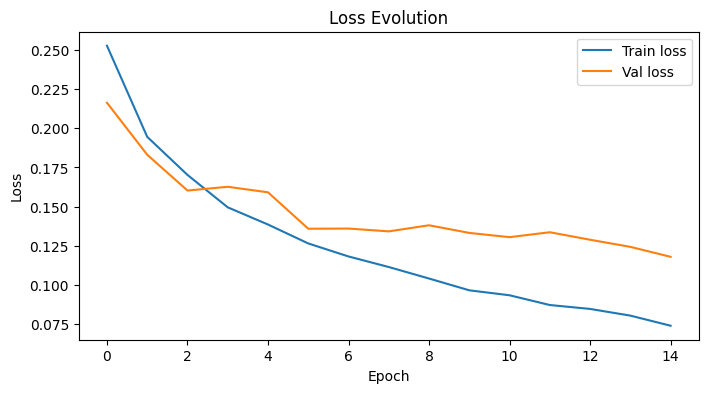

In [20]:
plot_losses(train_losses, val_losses, title="Loss Evolution")

Loading of the best model.

In [ ]:
best_epoch_path = list((save_dir.glob('best_epoch_*.pth')))[0]
net.load_state_dict(torch.load(best_epoch_path))


<All keys matched successfully>

### Results

#### Distance Matrix
Let's now visualize the distance matrix of embeddings and compare it to the distance matrix obtained in chapter 1. As with the training_utils.py file, I also created the plot_utils.py file.


Distance matrix heatmap saved at runs_koleo/20251228_174908/distance_matrix_heatmap.png


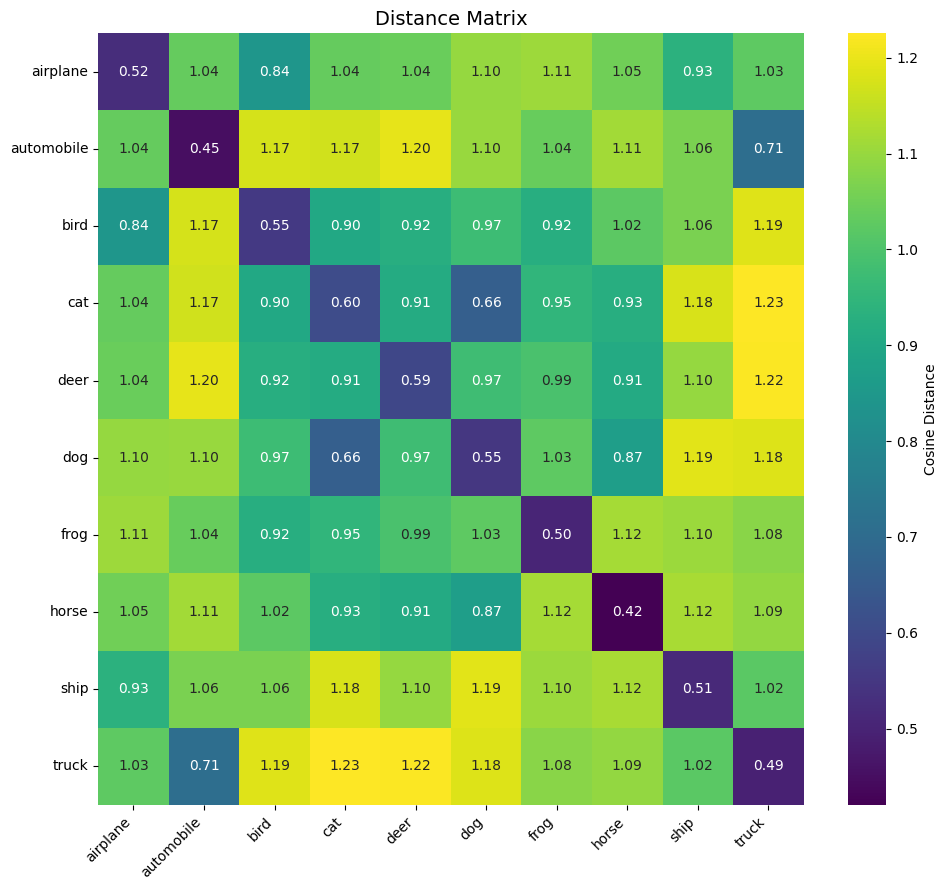


Intra-class distance: mean=0.5202, std=0.0545
Inter-class distance: mean=1.0350, std=0.1244
Separation margin: 0.5147


In [22]:
from plot_utils import compute_distance_matrix, plot_distance_matrix_heatmap
from training_utils import VAL_TRANSFORMS

embeddings_by_class = construct_embeddings_by_class(net, val_labels, val_triplets, VAL_TRANSFORMS, device)
dist_matrix = compute_distance_matrix(embeddings_by_class)
plot_distance_matrix_heatmap(dist_matrix, LABEL_NAMES, save_dir / "distance_matrix_heatmap.png")


Let's display the matrix obtained without the KoLeo loss.

![Distance matrix with simple triplet loss](../../runs/20251226_232950/distance_matrix_heatmap.png)


We can already observe that the distance values in the diagonals are lower when the model was trained with the simple triplet loss. This seems to indicate that the data is more spread out in their space.

| Metric | Without KoLeo | With KoLeo |
|--------|---------------|------------|
| Intra-class distance | mean=0.2249, std=0.0865 | mean=0.5202, std=0.0545 |
| Inter-class distance | mean=1.0392, std=0.2285 | mean=1.0350, std=0.1244 |
| Separation margin | 0.8143 | 0.5147 |

The comparison reveals that the KoLeo loss significantly increases intra-class distances (more than doubled from 0.2249 to 0.5202), confirming the greater spread of embeddings within each class. The inter-class distances remain similar (1.0392 vs 1.0350), while the separation margin decreases from 0.8143 to 0.5147, reflecting the trade-off between intra-class spread and inter-class separation.

Let's see what this looks like on a plane using PCA. We'll display the normalized version right away to compare with the previous projection.



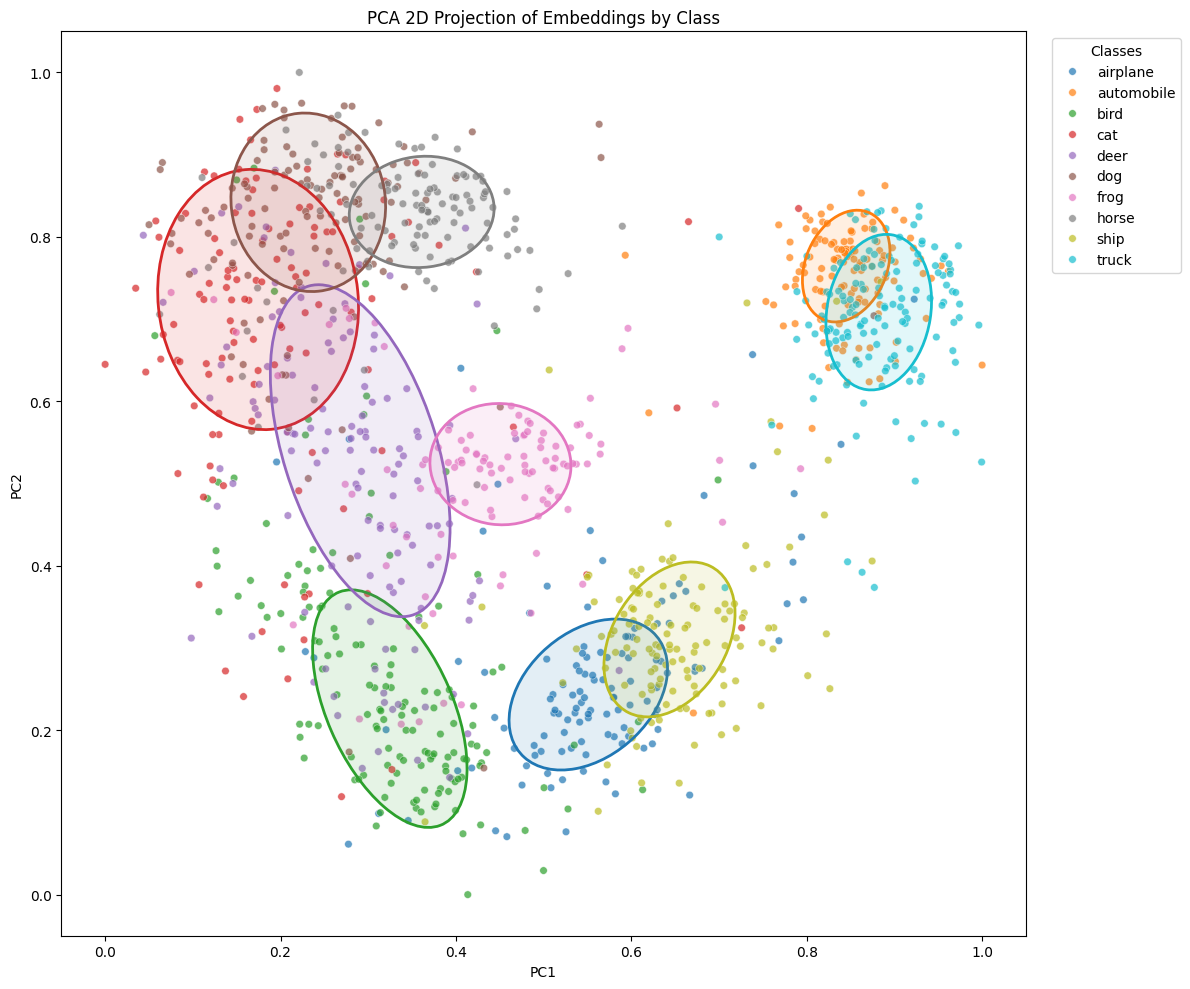

In [23]:
import numpy as np
from sklearn.decomposition import PCA

from plot_utils import get_ellipse_params_per_class, plot_embeddings_with_ellipses

all_embeddings = torch.cat([embeddings_by_class[k] for k in embeddings_by_class], dim=0)

pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(all_embeddings)
embeddings_2d = (embeddings_2d - embeddings_2d.min(axis=0)) / (embeddings_2d.max(axis=0) - embeddings_2d.min(axis=0))
samples_per_class = [len(embeddings_by_class[i]) for i in range(10)]

labels_array = np.concatenate([np.full(count, label) for label, count in enumerate(samples_per_class)])
ellipse_params = get_ellipse_params_per_class(embeddings_2d, labels_array, LABEL_NAMES, coverage=0.5)
plot_embeddings_with_ellipses(
    embeddings_2d,
    ellipse_params,
    labels_array,
    LABEL_NAMES,
    save_img_path = save_dir / "embeddings_2d_normalized.png",
)


Let's recall the projection without the KoLeo loss

![PCA projection with simple triplet loss](../../runs/20251226_232950/embeddings_2d.png)


The two PCA projections (with and without KoLeo loss) show notable differences. We observe that the KoLeo loss seems to indeed spread the embeddings more in space. The ellipses appear globally larger, which is consistent with the regularization objective: maximizing the minimum distance between representations.

To quantify this observation, let's calculate the areas of the ellipses for a few representative classes.


In [24]:
for k, v in ellipse_params.items():
    area = np.pi * v["width"] * v["height"]
    v["area"] = area

print("Ellipse areas (with KoLeo loss):")
for k in ["cat", "dog", "horse", "ship"]:
    print(f"  Area of {k}'s ellipse = {ellipse_params[k]['area']:.6f}")


Ellipse areas (with KoLeo loss):
  Area of cat's ellipse = 0.227323
  Area of dog's ellipse = 0.120206
  Area of horse's ellipse = 0.070161
  Area of ship's ellipse = 0.083406


Let's compare these values with those obtained without the KoLeo loss:

| Class | Without KoLeo | With KoLeo |
|-------|---------------|------------|
| cat   | 0.0626        | 0.2273     |
| dog   | 0.0392        | 0.1202     |
| horse | 0.0125        | 0.0702     |
| ship  | 0.0006        | 0.0834     |

The ellipse areas confirm this observation: all classes show larger ellipse areas when trained with the KoLeo loss, indicating a greater spread of embeddings in the representation space.

Results vary from one run to another depending on the seed and train/validation split. To have a more robust and statistically significant comparison, we will use k-fold cross-validation.


## K-Fold Implementation

We will use `KFold` from scikit-learn to divide our triplets into K=5 folds. 

K-fold cross-validation is a technique used to assess how a machine learning model generalizes to an independent dataset. The data is split into K approximately equal subsets ("folds"). For each of K iterations, one fold is held out as the validation set, and the model is trained on the remaining K-1 folds. This process allows each data point to be used for both training and validation, providing a more robust estimate of model performance.

Here an illustration of KFold when k=5.

![KFold illustration when k=5](../images/kfold.png)

For each fold, we will train two models: one with triplet loss alone, and one with triplet loss + KoLeo loss. We will then collect the ellipse areas for each class. 

To keep the computation time reasonable
- we switch to mps device like said at the beggining of this article
- we reduce the number of training epochs per fold, since running many epochs for each model and fold would take too long.



In [25]:
from sklearn.model_selection import KFold

import copy

K_FOLDS = 5
EPOCHS_PER_FOLD = 7

kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=seed)

device = get_device()

results_no_koleo = {"areas": {cls: [] for cls in LABEL_NAMES}, "auc": []}
results_with_koleo = {"areas": {cls: [] for cls in LABEL_NAMES}, "auc": []}


We define a function that trains a model and returns the ellipse areas. We will also ensure that the training loader always returns the same data for both trainings by initializing the seed just before the training loop. We also add more data for the final experiment.


In [29]:
from torch.utils.data import DataLoader
from torchvision.models import VGG11_Weights
from tqdm import tqdm

from training_utils import TripletsCIFAR10Dataset, TRAIN_TRANSFORMS

def train_and_compute_metrics(train_triplets, val_triplets, val_labels, use_koleo, epochs=2):
    train_dataset = TripletsCIFAR10Dataset(train_triplets, transform=TRAIN_TRANSFORMS)
    val_dataset = TripletsCIFAR10Dataset(val_triplets, transform=VAL_TRANSFORMS)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = VGG11Embedding(weights=VGG11_Weights.IMAGENET1K_V1).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    kw = koleo_weight if use_koleo else 0.0
    
    best_auc = 0.0
    best_model_state = None
    
    torch.manual_seed(seed)
    for epoch in tqdm(range(epochs)):
        model.train()
        for anc, pos, neg in train_loader:
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
            anc_feat, pos_feat, neg_feat = model(anc), model(pos), model(neg)
            
            loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)
            if use_koleo:
                all_emb = torch.cat([anc_feat, pos_feat, neg_feat], dim=0)
                loss += kw * koleo_loss_fn(all_emb)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        val_metrics = validation_loop(model, val_loader, margin, kw if use_koleo else None, device)
        current_auc = val_metrics['val_auc']
        
        if current_auc > best_auc:
            best_auc = current_auc
            best_model_state = copy.deepcopy(model.state_dict())
    
    model.load_state_dict(best_model_state)
    
    embeddings_by_class = construct_embeddings_by_class(model, val_labels, val_triplets, VAL_TRANSFORMS, device)
    all_emb = torch.cat([embeddings_by_class[k] for k in embeddings_by_class], dim=0)

    dist_matrix = compute_distance_matrix(embeddings_by_class)
    
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(all_emb)
    emb_2d = (emb_2d - emb_2d.min(axis=0)) / (emb_2d.max(axis=0) - emb_2d.min(axis=0))
    
    samples = [len(embeddings_by_class[i]) for i in range(10)]
    lab_arr = np.concatenate([np.full(c, l) for l, c in enumerate(samples)])
    
    ellipse_p = get_ellipse_params_per_class(emb_2d, lab_arr, LABEL_NAMES, coverage=0.5)
    
    areas = {}
    for cls in LABEL_NAMES:
        areas[cls] = np.pi * ellipse_p[cls]["width"] * ellipse_p[cls]["height"]
    
    return {
        "areas": areas,
        "auc": best_auc,
        "embeddings_by_class": embeddings_by_class,
        "dist_matrix": dist_matrix,
        "emb_2d": emb_2d,
        "lab_arr": lab_arr,
        "ellipse_params": ellipse_p
    }


### Training
Let's now launch the cross-validation. Note: this cell may take several minutes to execute (K folds × 2 models × epochs) = 5 x 2 x 7 = 10 trainings of 7 epochs each = 70 epochs.


In [ ]:
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(triplets)):
    print(f"\n{'='*50}")
    print(f"Fold {fold_idx + 1}/{K_FOLDS}")
    print(f"{'='*50}")
    
    fold_train_triplets = triplets[train_idx]
    fold_val_triplets = triplets[val_idx]
    fold_train_labels = triplets_labels[train_idx]
    fold_val_labels = triplets_labels[val_idx]
    
    print(f"Training WITHOUT KoLeo loss...")
    metrics_no_koleo = train_and_compute_metrics(
        fold_train_triplets, 
        fold_val_triplets, fold_val_labels, 
        use_koleo=False, epochs=EPOCHS_PER_FOLD
    )
    for cls in LABEL_NAMES:
        results_no_koleo["areas"][cls].append(metrics_no_koleo["areas"][cls])
    results_no_koleo["auc"].append(metrics_no_koleo["auc"])
    print(f"  Best AUC: {metrics_no_koleo['auc']:.4f}")
    
    print(f"Training WITH KoLeo loss...")
    metrics_with_koleo = train_and_compute_metrics(
        fold_train_triplets, 
        fold_val_triplets, fold_val_labels, 
        use_koleo=True, epochs=EPOCHS_PER_FOLD
    )
    for cls in LABEL_NAMES:
        results_with_koleo["areas"][cls].append(metrics_with_koleo["areas"][cls])
    results_with_koleo["auc"].append(metrics_with_koleo["auc"])
    print(f"  Best AUC: {metrics_with_koleo['auc']:.4f}")
    
    print(f"Fold {fold_idx + 1} done.")



Fold 1/5
Training WITHOUT KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:15<00:00, 36.45s/it]


  Best AUC: 0.9140
Training WITH KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:12<00:00, 36.08s/it]


  Best AUC: 0.9186
Fold 1 done.

Fold 2/5
Training WITHOUT KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:19<00:00, 62.82s/it]


  Best AUC: 0.9194
Training WITH KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:33<00:00, 39.10s/it]


  Best AUC: 0.9126
Fold 2 done.

Fold 3/5
Training WITHOUT KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:50<00:00, 41.51s/it]


  Best AUC: 0.9270
Training WITH KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:53<00:00, 41.94s/it]


  Best AUC: 0.9214
Fold 3 done.

Fold 4/5
Training WITHOUT KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:58<00:00, 42.62s/it]


  Best AUC: 0.9301
Training WITH KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:02<00:00, 43.20s/it]


  Best AUC: 0.9253
Fold 4 done.

Fold 5/5
Training WITHOUT KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:00<00:00, 42.88s/it]


  Best AUC: 0.9300
Training WITH KoLeo loss...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:10<00:00, 44.36s/it]


  Best AUC: 0.9217
Fold 5 done.


### Results

In [ ]:
auc_no_koleo = np.array(results_no_koleo["auc"])
auc_with_koleo = np.array(results_with_koleo["auc"])

print("=" * 70)
print("AUC SCORES")
print("=" * 70)
print(f"Without KoLeo: {auc_no_koleo.mean():.4f} +/- {auc_no_koleo.std():.4f}")
print(f"With KoLeo: {auc_with_koleo.mean():.4f} +/- {auc_with_koleo.std():.4f}")

print("\n" + "=" * 70)
print("ELLIPSE AREAS")
print("=" * 70)
print(f"{'Class':<12} | {'Without KoLeo (mean +/- std)':<25} | {'With KoLeo (mean +/- std)':<25}")
print("-" * 70)

for cls in ["cat", "dog", "horse", "ship"]:
    no_koleo_arr = np.array(results_no_koleo["areas"][cls])
    with_koleo_arr = np.array(results_with_koleo["areas"][cls])
    
    print(f"{cls:<12} | {no_koleo_arr.mean():.4f} +/- {no_koleo_arr.std():.4f}        | {with_koleo_arr.mean():.4f} +/- {with_koleo_arr.std():.4f}")

print("\n" + "=" * 70)
print("Average area across all classes:")

all_no_koleo = np.array([np.mean(results_no_koleo["areas"][cls]) for cls in LABEL_NAMES])
all_with_koleo = np.array([np.mean(results_with_koleo["areas"][cls]) for cls in LABEL_NAMES])

print(f"  Without KoLeo: {all_no_koleo.mean():.4f} +/- {all_no_koleo.std():.4f}")
print(f"  With KoLeo: {all_with_koleo.mean():.4f} +/- {all_with_koleo.std():.4f}")


AUC SCORES
Without KoLeo: 0.9241 +/- 0.0064
With KoLeo: 0.9199 +/- 0.0042

ELLIPSE AREAS
Class        | Without KoLeo (mean +/- std) | With KoLeo (mean +/- std)
----------------------------------------------------------------------
cat          | 0.1438 +/- 0.0378        | 0.2196 +/- 0.1077
dog          | 0.0725 +/- 0.0375        | 0.1493 +/- 0.0693
horse        | 0.0646 +/- 0.0370        | 0.1102 +/- 0.0463
ship         | 0.0513 +/- 0.0275        | 0.0828 +/- 0.0201

Average area across all classes:
  Without KoLeo: 0.0868 +/- 0.0356
  With KoLeo: 0.1377 +/- 0.0526


 
Cross-validation allows us to draw more robust conclusions about the effect of the KoLeo loss. 

The AUC score, which measures the model's ability to distinguish positive pairs from negative pairs, shows minimal impact: without KoLeo we obtain 0.9241 ± 0.0064, while with KoLeo we obtain 0.9199 ± 0.0042. 

The slight decrease in mean AUC is accompanied by a reduction in variance (0.0042 vs 0.0064), indicating more stable performance across different data splits. 

The ellipse areas are systematically larger with the KoLeo loss across all classes, confirming that the regularization indeed spreads the embeddings in space. The average area increases from 0.0868  to 0.1377, representing an increase of approximately 59%. This increase is consistent across all classes. 

The results demonstrate a clear trade-off: the KoLeo loss achieves its objective of spreading embeddings while maintaining similar discrimination quality. The slight decrease in mean AUC is a small price to pay for the increased spread, which can improve generalization. The effect depends on the chosen `koleo_weight`, and the regularization appears to be working as intended.

In the next part, we will study the impact of gradient accumulation on this behavior, as the KoLeo loss is intrinsically dependent on batch size.


## Effect of KoLeo loss weight

So far, we have compared training with and without the KoLeo loss. However, the weight $\lambda$ in the total loss $\mathcal{L} = \mathcal{L}_{triplet} + \lambda\mathcal{L}_{KoLeo}$ is a hyperparameter that controls the strength of the regularization. A larger $\lambda$ should encourage a greater spread of embeddings, but may also affect the discrimination quality.

To understand this trade-off, we will train four models with different KoLeo loss weights: $\lambda$ = 1.0, 0.5 (since we already done 0.1), 0.01, and 0.001. All models will be trained on the same train/validation split to ensure a fair comparison. Note that the goal here is not to find the best model, but rather to observe how the weight parameter affects the behavior of the embeddings. We defer this to a later time, where we will conduct a proper hyperparameter search.

### Training

In [30]:
koleo_weights = [1.0, 0.5, 0.01, 0.001]
results = {}

epochs = 7

for koleo_weight in koleo_weights:
    print(f"\n{'='*60}")
    print(f"Training with koleo_weight = {koleo_weight}")
    print(f"{'='*60}")
    
    num_train = int((1 - val_split) * len(triplets))
    np.random.seed(seed)
    shuffle_indices = np.random.permutation(len(triplets))
    shuffled_triplets = triplets[shuffle_indices]
    shuffled_triplets_labels = triplets_labels[shuffle_indices]

    train_triplets = shuffled_triplets[:num_train]
    val_triplets = shuffled_triplets[num_train:]
    val_labels = shuffled_triplets_labels[num_train:]
    results[koleo_weight] = train_and_compute_metrics(train_triplets, val_triplets, val_labels, use_koleo=True, epochs=epochs)
    
    print(f"Best AUC: {results[koleo_weight]['auc']:.4f}")


Training with koleo_weight = 1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:21<00:00, 45.97s/it]


Best AUC: 0.7820

Training with koleo_weight = 0.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:32<00:00, 56.11s/it]


Best AUC: 0.8845

Training with koleo_weight = 0.01


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:16<00:00, 53.84s/it]


Best AUC: 0.9320

Training with koleo_weight = 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:18<00:00, 62.64s/it]


Best AUC: 0.9281


### Results

For each training, we display the distance matrix and the PCA projection of the embeddings, then we will print a dataframe to compare the metrics we follow from the beginning of the study.

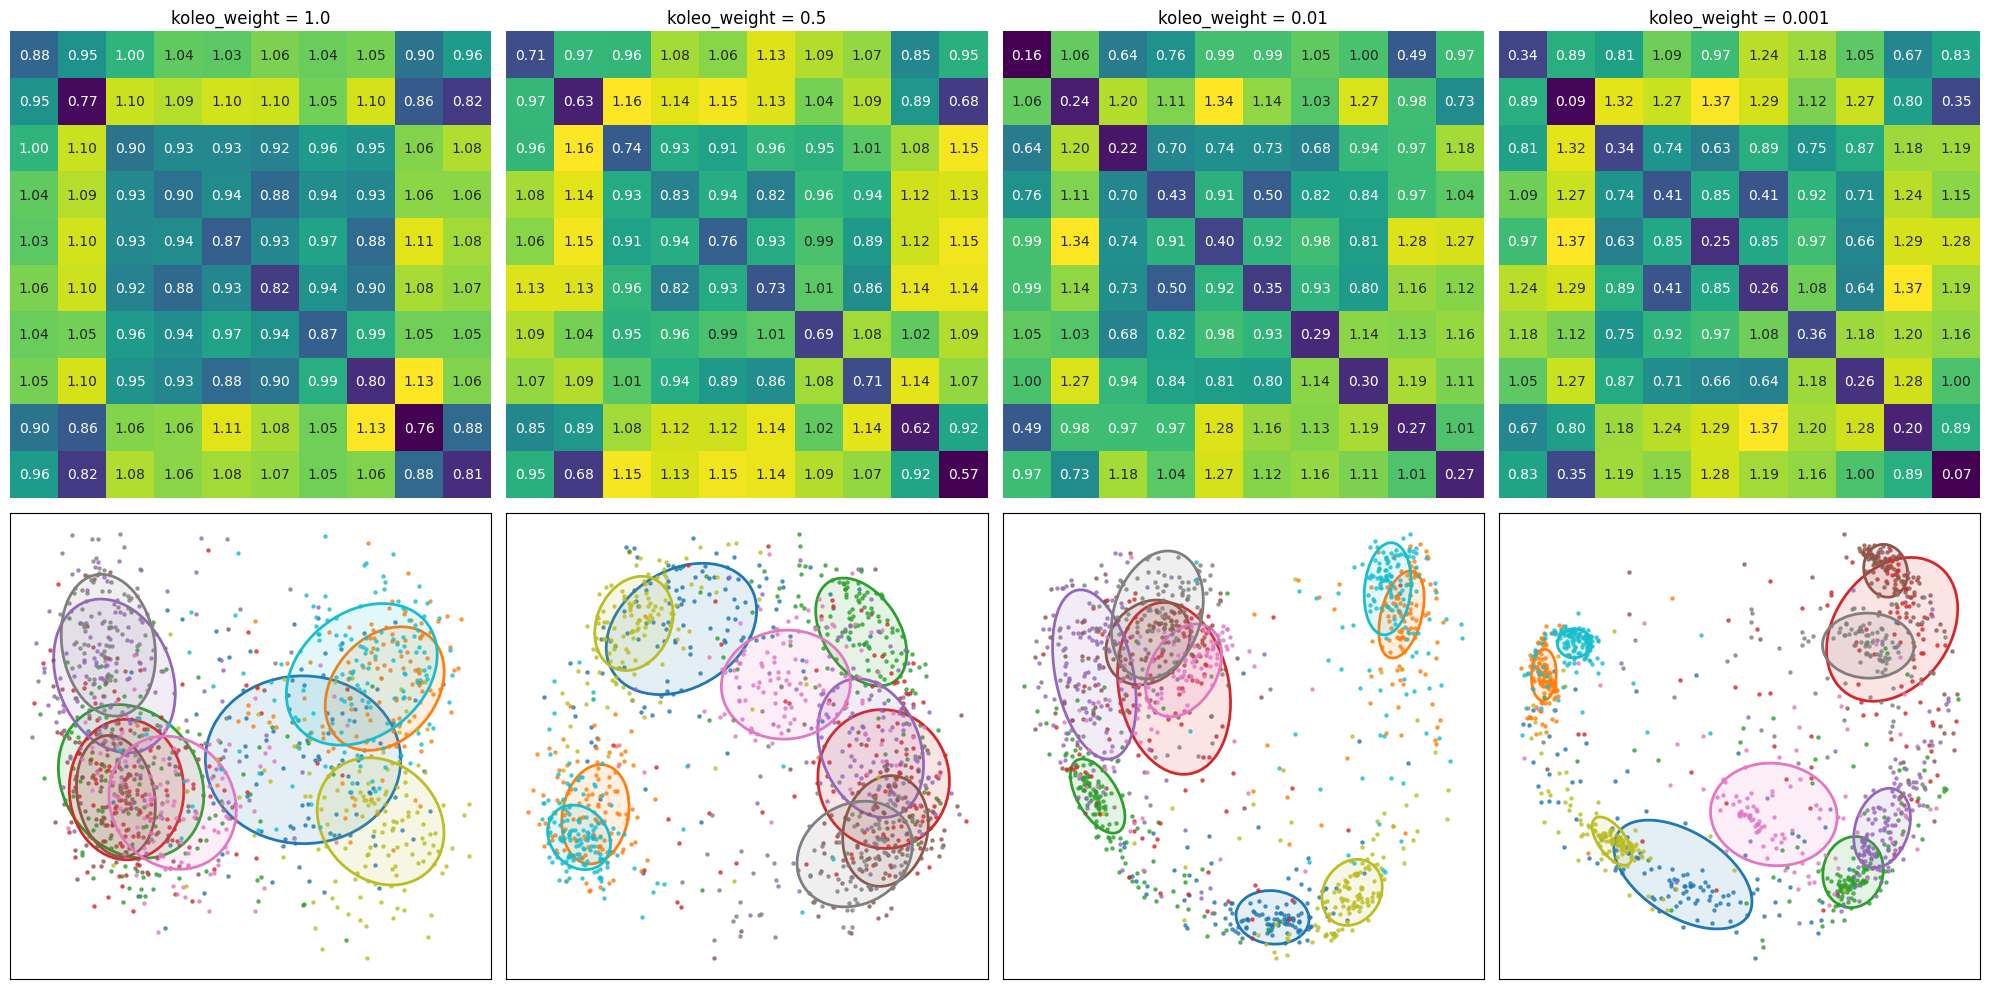

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for col_idx, kw in enumerate(koleo_weights):
    data = results[kw]
    
    ax_dist = axes[0, col_idx]
    sns.heatmap(
        data["dist_matrix"],
        xticklabels=False,
        yticklabels=False,
        annot=True,
        fmt='.2f',
        cmap='viridis',
        cbar=False,
        ax=ax_dist
    )
    ax_dist.set_title(f'koleo_weight = {kw}', fontsize=12)
    ax_dist.set_xticklabels(ax_dist.get_xticklabels(), rotation=45, ha='right')
    
    ax_pca = axes[1, col_idx]
    pca_df = pd.DataFrame({
        'PC1': data["emb_2d"][:, 0],
        'PC2': data["emb_2d"][:, 1],
        'Label': data["lab_arr"]
    })
    
    palette = sns.color_palette("tab10", n_colors=10)
    class_names = sorted(LABEL_NAMES)
    color_map = {cls: palette[i] for i, cls in enumerate(class_names)}
    
    for cls_idx, cls in enumerate(class_names):
        mask = pca_df['Label'] == cls_idx
        ax_pca.scatter(
            pca_df.loc[mask, 'PC1'],
            pca_df.loc[mask, 'PC2'],
            c=[color_map[cls]],
            alpha=0.7,
            s=5,
            label=None
        )
        ax_pca.set_xticks([])
        ax_pca.set_yticks([])
        ax_pca.set_xlabel('')
        ax_pca.set_ylabel('')
        
        ep = data["ellipse_params"][cls]
        center, w, h, angle = ep["center"], ep["width"], ep["height"], ep["angle"]
        color = color_map[cls]
        ellipse = Ellipse(
            xy=center, width=w, height=h, angle=angle,
            facecolor=(*color, 0.12), edgecolor=color, linewidth=2
        )
        ax_pca.add_patch(ellipse)
    
plt.tight_layout()
plt.show()

In [40]:
metrics_data = []

for kw in koleo_weights:
    data = results[kw]
    avg_area = np.mean([data["areas"][cls] for cls in LABEL_NAMES])
    
    metrics_data.append({
        'koleo_weight': kw,
        'AUC': data["auc"],
        'Average Area': avg_area,
        'cat': data["areas"]["cat"],
        'dog': data["areas"]["dog"],
        'horse': data["areas"]["horse"],
        'ship': data["areas"]["ship"]
    })

df_metrics = pd.DataFrame(metrics_data)
print(df_metrics.to_string(index=False))

 koleo_weight      AUC  Average Area      cat      dog    horse     ship
        1.000 0.782031      0.303399 0.272510 0.159597 0.224118 0.269065
        0.500 0.884517      0.192656 0.309264 0.159165 0.203266 0.122403
        0.010 0.931963      0.129995 0.324318 0.118596 0.193741 0.066706
        0.001 0.928076      0.109786 0.306128 0.039175 0.100779 0.026143


## Conclusion

In this chapter, we have explored the KoLeo loss as a regularization technique for Siamese networks. Through several experiments, we have gained insights into its behavior and effects.

**Cross-validation results** demonstrated that the KoLeo loss successfully achieves its primary objective: spreading embeddings in the representation space.

**The effect of the weight parameter** was further investigated by training models with different $\lambda$ values (1.0, 0.5, 0.01, and 0.001). The results reveal a clear trade-off: as the KoLeo loss weight increases, the spread of embeddings (measured by ellipse areas) increases.

This trade-off highlights the importance of carefully choosing the weight parameter based on the specific requirements of the task. A larger weight may be beneficial when generalization and spread are priorities, while a smaller weight may be preferred when discrimination quality is critical.

The KoLeo loss has proven to be an effective regularization technique that can improve the distribution of embeddings in the representation space. However, as we noted, the loss is intrinsically dependent on batch size, which raises questions about the impact of gradient accumulation, a topic we will explore in the next chapter.